In [1]:
import os
import pandas as pd
from anndata import read_h5ad
import scanpy as sc
import seaborn as sns
import scregseg
import matplotlib.pyplot as plt
from pybedtools import BedTool
from scregseg.visualize import plot_fragmentsize, plot_locus
from IPython.display import display, HTML

from coolbox.api import *
from scregseg.visualize import plot_locus
from scregseg.scregseg import get_statecalls
from scregseg.scregseg import to_bedtool

Using TensorFlow backend.
/home/wkopp/anaconda3/envs/scregseg2/lib/python3.7/site-packages/numpydoc/docscrape.py:418: UserWarning: Unknown section Return
  warn(msg)


In this tutorial we show how to

    1. employ Scregseg to segment the genome based on pseudo-bulk ATAC-seq data. That is, subsets of cells within which the signal is collapsed.
    2. evaluate the Scregseg results and the state.
    3. perform a gene set enrichment
    4. extract state-specific genes
    5. visualize example regions

In [2]:
geneannotation = os.path.join('annotation', 'geneannot_hg19.bed')

# Scregseg on pseudo-bulk ATAC-seq data

We can employ the HMM model not only on the single-cell resolution tracks,
but also on e.g. pseudo-bulk tracks
in order to characterize the regulatory landscape across pre-defined groups of cells.

This enables to take advantage of upstream analysis steps, including dimensionality reduction and cell clustering results, and may reveal states reflecting cluster-specific or shared accessibility profiles across cell populations in an unbiased manner.

![Scregseg scheme](scregseg_pi_scheme_v2.svg)

We continue with the 10x Genomics datasets that we have prepared in tutorial 01.

### Model fitting

The HMM-model for genome segmentation can be fitted using `scregseg fit_segment` like in the previous tutorial. The only difference is that now we make use of the pseudo-bulk collapsed counts.

In the example, we shall use a 30 state model and run the model on 30 cores to speedup the parameter fitting step.

The model parameters and state calling results as well as some statistics about the states
are saved in the directory `scregseg_pi`

In [2]:
!scregseg fit_segment --counts collapsed_countmatrix_500.h5ad \
    --storage scregseg_pi_v2 \
    --randomseed 32 --n_jobs 30 --nstates 30

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
         1  -168982617.2166             +nan
         2  -165893826.4344    +3088790.7822
         3  -163289248.8235    +2604577.6108
         4  -162434637.0237     +854611.7999
         5  -1

### Exploring the model results

After having fitted a model and called states, we can explore some initial statistics about the states similarly as in the previous tuturial on single-cell resolution segmentation.

Load the Scregseg results:

In [4]:
model = scregseg.Scregseg.load(os.path.join('scregseg_pi_v2', 'dirmulhmm'))

The first indication about the likely functional relevance of a states is given by the state frequency.
That is, how much of the genome is covered by a give state.

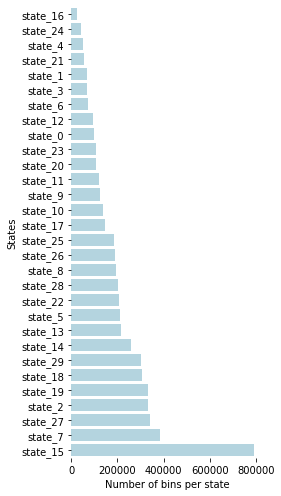

In [5]:
fig, ax =  plt.subplots(figsize=(4,7))
model.plot_state_frequency(ax=ax)
plt.tight_layout()

We find one state (state_15) which is particularly abundant and thus, probably reflecting genomic background.
On the other hand, a number of states occur rarely and may reflect biologically functional states (e.g. state_23, state_0, etc.)

In agreement with the previous tutorial, rare states tend to be associated with higher read coverage across cells.

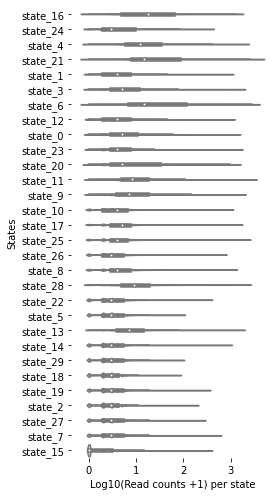

In [6]:
fig, ax =  plt.subplots(figsize=(4,7))
model.plot_readdepth(ax=ax)
plt.tight_layout()

In [7]:
adata = read_h5ad('filtered_countmatrix.h5ad')

We can explore the state to cluster association by inspecting the emission probabilities of the model.
These have been normalized by read depth/cluster size and log transformed in order to enhance the interpretability.
States exhibiting an excess of reads for a given cluster (relative to an average genomic background signal) are shown in red. A depletion of reads is reflected in shades of blue.

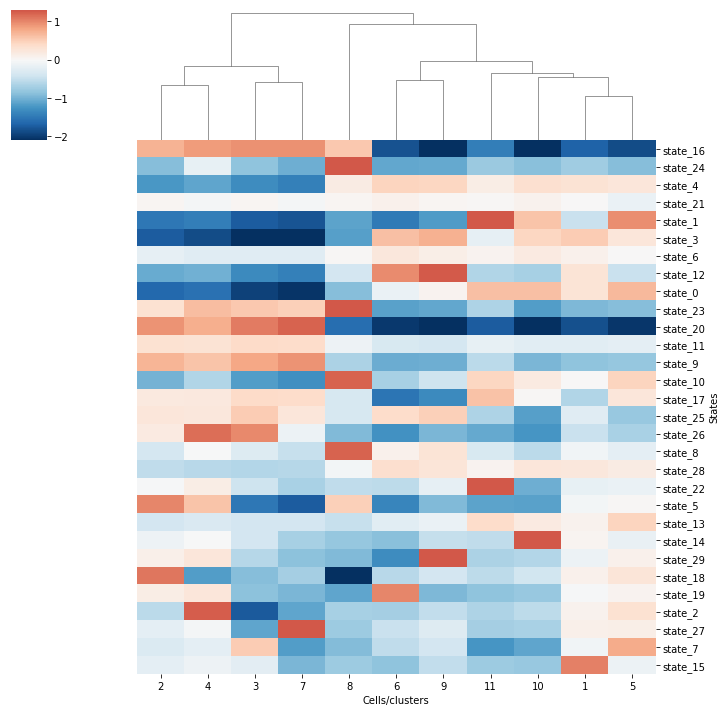

In [8]:
_ = model.plot_emissions()

This representation might point to cell-type specific accessibility profiles, but it might also capture accessibility profiles that are shared across multiple cell-types. Therefore, it captures the accessibility profiles in an unbiased manner, because complex combinatorial accessibility profiles are revealed automatically.

### Gene set enrichment

Next, we test the enrichment of state calls around pre-defined marker genes for various blood cell types.

In [11]:
genesets = {
    'B-cells':'annotation/genesets/bcell.bed',
    'T-cells cd8+': 'annotation/genesets/cd8plus-t-cell.bed',
   # 'fcgr3aplus-mono': 'annotation/genesets/fcgr3aplus-mono.bed',
    'T-cells naive-cd4+': 'annotation/genesets/naive-cd4plus-t-cell.bed',
    'Monocytes cd14+': 'annotation/genesets/cd14plus-mono.bed',
    #'dc': 'annotation/genesets/dc.bed',
    'Memory cells': 'annotation/genesets/memory-cd4plus-t-cell.bed',
    'NK cells': 'annotation/genesets/nk.bed',
}

First, we count the state calls around the TSSs (+/- 10kb) for the gene sets.

In [10]:
state_counts, _, _ = model.geneset_observed_state_counts(genesets, 
                                                         flanking=10000, 
                                                         using_tss=True)

Then we compute the fold-enrichment of the observed number of state calls compared to the
expected number of state calls (based on the overall state frequency).

In [15]:
enrichment = model.broadregion_enrichment(state_counts, mode='logfold')

In [16]:
enrichment

,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,...,state_20,state_21,state_22,state_23,state_24,state_25,state_26,state_27,state_28,state_29
B-cells,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.393285,...,0.000000,0.35097,0.0,0.920689,1.636526,0.000000,0.0,0.000000,0.000000,0.0
T-cells cd8+,1.495819,0.00000,0.000000,0.977658,0.000000,0.000000,0.000000,0.443463,0.000000,0.000000,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.110373,0.0
T-cells naive-cd4+,0.080846,0.00000,0.000000,1.313450,0.845627,-0.206655,0.000000,0.000000,-0.146577,0.000000,...,0.000000,0.00000,0.0,0.000000,0.000000,0.151005,0.0,0.000000,0.462556,0.0
Monocytes cd14+,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.255354,-0.225544,0.000000,1.106495,...,1.074152,0.04994,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.286465,0.0
Memory cells,0.000000,0.00000,0.000000,1.153749,-0.154373,-0.206655,0.130415,0.000000,0.000000,0.656526,...,0.052963,0.35097,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.462556,0.0
NK cells,0.000000,1.45294,0.032643,0.000000,0.000000,0.000000,0.352264,0.200425,0.000000,-0.384867,...,0.052963,0.35097,0.0,0.000000,0.000000,0.000000,0.0,-0.660444,-0.491687,0.0


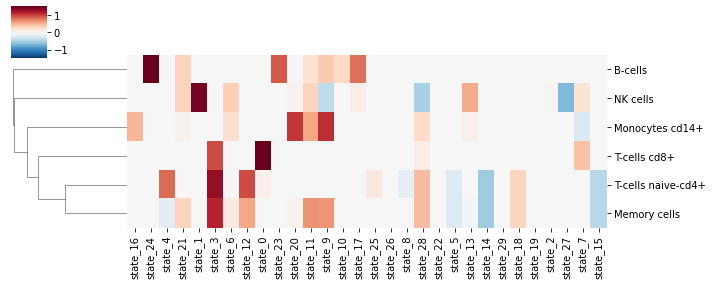

In [18]:
sns.clustermap(enrichment.loc[:,model.get_statenames()], cmap="RdBu_r", figsize=(10,4), 
               robust=True, 
               col_cluster=False,
               **{'center':0.0, 'vmin':-1.5, 'vmax':1.5})

The heatmap illustrate the association of states with gene sets. For instance, 
state_24 seems to be associated with B-cells and state_1 primarily with NK cells.

### State-specific genes

Next, we try to extract state-specific genes. 
To this end, we test whether a specific state is particularly enriched around the TSS (+/- 10kb) of a given gene
using a similar enrichment strategy as above for the gene enrichment test.

In [50]:
state_counts, _, _ = model.observed_state_counts(geneannotation, 
                                                   flanking=10000, 
                                                   using_tss=True)
enrichment = model.broadregion_enrichment(state_counts, mode='logfold')
display(HTML((pd.melt(enrichment.reset_index(), 
                      id_vars='index').groupby('variable')[['index', 
                                                            'value']].apply(lambda x: 
                                                                            x.nlargest(10, 
                                                                                       columns=['value'])).to_html())))

A list of most associated gene per state is shown in the table above.

### Visualize genome-browser example regions

Finally, we shall visualize the cluster-collapsed signal tracks of an example region
along with the annotation derived from the segmentation model.

First, we extract state calls from the model. Here, we restrict attention to
a specific set of states. The get_statecalls function also allows to filter for state calling confidence
or merge adjacent regions with the same state call.

In [13]:
segm,_ = get_statecalls(model._segments, 
                        ['state_16', 'state_24',
                        'state_4', 'state_21','state_1','state_3','state_6','state_12','state_0',
                        'state_23','state_20','state_11','state_9'], 
                      ntop=-1,
                     collapse_neighbors=True,
                     )

In [14]:
bed = to_bedtool(segm)

In [16]:
bed.moveto('./statecalls.bed')

<BedTool(./statecalls.bed)>

For this example, we continue with the cell clustering results
that is obtained from the 10x Genomics pipeline.

In [25]:
df = pd.read_csv('analysis/clustering/graphclust/clusters.csv')
df.columns = ['barcode', 'Cluster']
df.set_index('barcode', inplace=True)
df.Cluster = df.Cluster.astype(str).astype('category')

The following function allows to visualize the pseudobulk tracks of the fragments file.
The visualization is built based on the coolbox package

[WARNING:plot.py:59 -           plot_genes()] *WARNING* Color set to 'bed_rgb', but bed file does not have the rgb field. The color has been set to #1f78b4


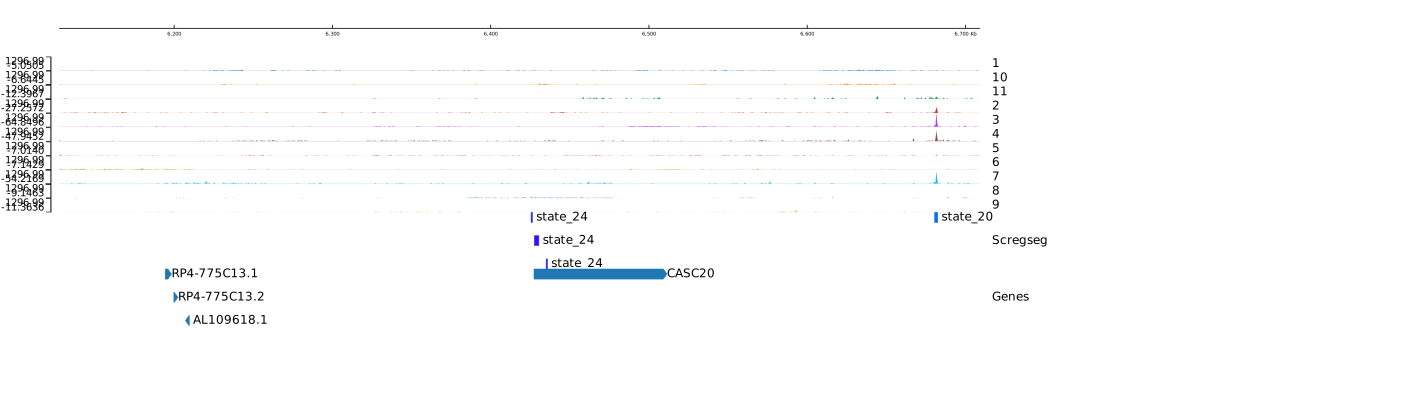

In [52]:
f = plot_locus('chr20:6227369-6609106',
               'Cluster', df,
               frames_before=Frame(width=5)+XAxis(fontsize=5),
               frames_after=BED('./statecalls.bed', title="Scregseg") + BED('./geneannot_hg19.bed',title="Genes"),
               files='atac_v1_pbmc_5k_fragments.tsv.gz',
               extend_window=100000,
               height=.9,
               binsize=500,
               add_total=False,
               add_data_ranges=False
              )
f

This locus exhibits state calls of two states, state_24 which exhibits accessibility in cluster 8  
and state_20 which exhibits accessibility in the clusters 2, 3, 4 and 7.
High confidence state_24 calls are located close to the promoter of CASC20. In the accessibility tracks above,
one can appreciate an elevated broad accessibility signal starting before CASC20 and stretching into the gene body.